<a href="https://colab.research.google.com/github/Hasim-dev/trafficsigns/blob/master/Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

Cloning into 'master'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
!ls master

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
# kullanacağımız datayı unpickle edip "train, val, test_data"ya atıyoruz.

with open('master/train.p', 'rb') as f:
  train_data = pickle.load(f) # dictionary of data
with open('master/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('master/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
print(type(train_data))

# Dataseti kullanacak hâle getiriyoruz.
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [0]:
# Datayı kontrol ettik
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
# Her görüntünün bir labeli olduğunu kontrol ediyoruz.
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32x32x3."
assert(X_val.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32x32x3."
assert(X_test.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32x32x3."

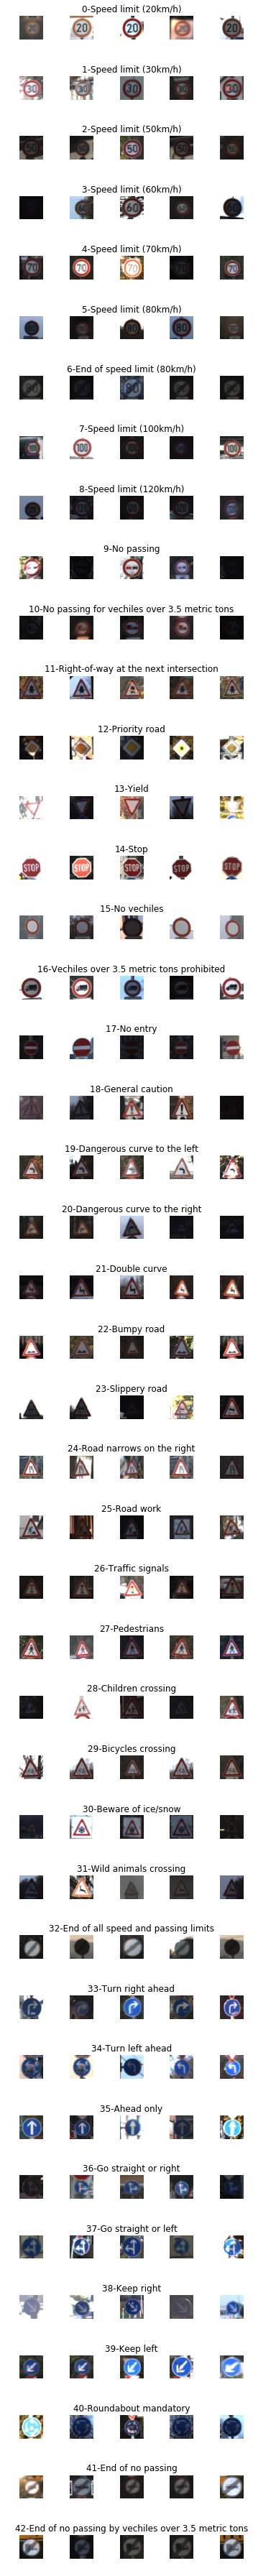

In [0]:
#Data görüntüleme
data = pd.read_csv('master/signnames.csv')

#Datayı grid hâlinde görüntüleme

num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():# data.iterrows(): iterate over dataframe rows
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-" + row["SignName"])
        num_of_samples.append(len(x_selected))
        

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


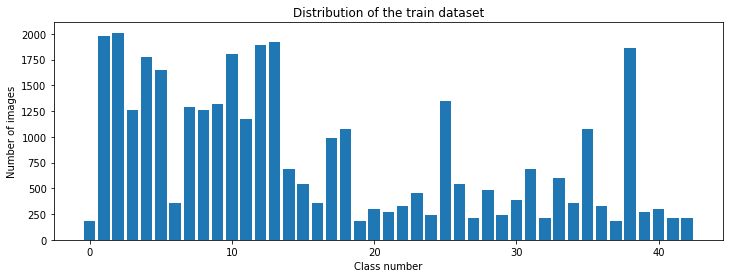

In [0]:
# Her sınıfta kaç adet veri olduğunu görmek için

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


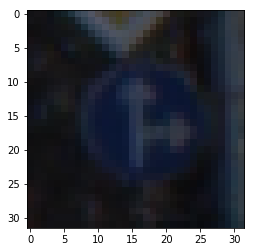

In [0]:
# PREPROCESS İŞLEMİ

import cv2

plt.imshow(X_train[1000])
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


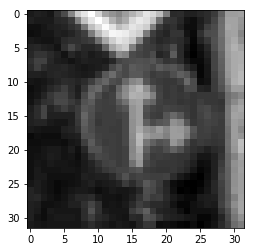

In [0]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap("gray"))
print(img.shape)

(32, 32)


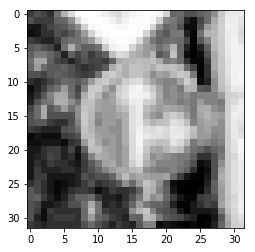

In [0]:
# Görüntüleri aynı ışıklandırma seviyesine getirme (histogram eşitleme (normalize etme))

def equalize(img):
  img = cv2.equalizeHist(img) # equalizeHist sadece grayscale img alır. (1 derinlikli)
  return img

img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap("gray"))
print(img.shape)


In [0]:
# Preprocess etme
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255 # Görüntüyü normalize etme (0-255 arasında olan piksel değerlerinin 0-1 arasında olması için)
  return img

X_train = np.array(list(map(preprocessing, X_train))) # map(): Training Seti preprocess etme. map(), list() döndürür
X_val = np.array(list(map(preprocessing, X_val)))     #    Array'deki her eleman için fonksiyonu uygular ve günceller.
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


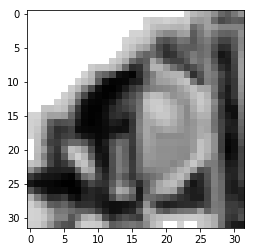

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap=plt.get_cmap("gray"))
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
datagen.fit(X_train)

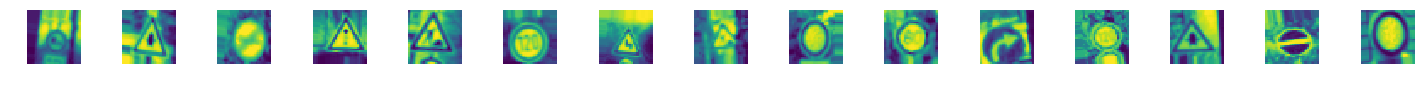

In [0]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
# Labelları one-hot encode etme
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  # Convolutional Layer
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(0.5))
  
  #Flattening Layer
  model.add(Flatten())
  # FC Layer
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))                         # Dropout Layer
  model.add(Dense(num_classes, activation='softmax'))    # Output Layer
  # Compile model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model 

In [0]:
model = modified_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
2000/2000 [==============================] - 36s 18ms/step - loss: 0.8154 - acc: 0.7614 - val_loss: 0.0672 - val_acc: 0.9823
Epoch 2/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.1920 - acc: 0.9398 - val_loss: 0.0405 - val_acc: 0.9857
Epoch 3/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1266 - acc: 0.9600 - val_loss: 0.0281 - val_acc: 0.9925
Epoch 4/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.1028 - acc: 0.9681 - val_loss: 0.0373 - val_acc: 0.9889
Epoch 5/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0823 - acc: 0.9747 - val_loss: 0.0280 - val_acc: 0.9939
Epoch 6/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0728 - acc: 0.9781 - val_loss: 0.0322 - val_acc: 0.9889
Epoch 7/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0670 - acc

Text(0.5, 0, 'epoch')

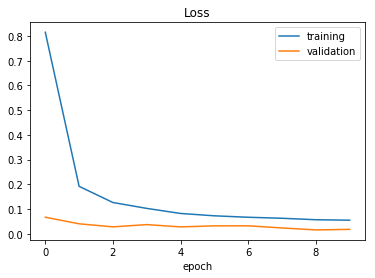

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

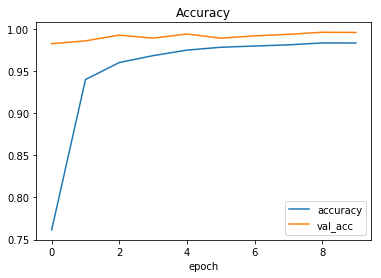

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose= 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.11399619207510583
Test Accuracy: 0.9745843230592572


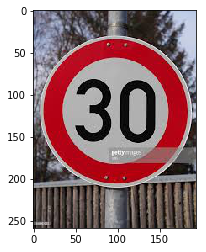

In [0]:
import requests
from PIL import Image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9ZU74rUSI017s2qkzElOkyTKBYI4gIVAjXTWJ5dqvjDDxuOnd'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


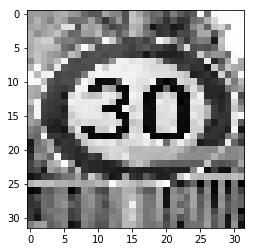

In [0]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1, 32, 32, 1)

In [0]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]
